In [66]:
import geopandas as gpd
import pandas as pd
from shapely import wkt
import matplotlib.pyplot as plt
import rasterio
from rasterio.features import rasterize

# Bounding box und Geometrie für Sentinel-Abfrage

In [151]:
df_raw = pd.read_csv('bern_landkult.csv')
labels = pd.read_csv('../Level_hierarchy.csv', usecols=['level3', 'LNF_code'])
labels.columns=['level3', 'LNF_CODE']

In [153]:
df_landkult = pd.merge(df_raw, labels, how='left', on='LNF_CODE' )
df_landkult = df_landkult.dropna(subset = ['level3'])

In [154]:
df_landkult['geometry'] = df_landkult['geometry'].apply(wkt.loads)
crs = {'init': 'epsg:2056'}
gdf = gpd.GeoDataFrame(df_landkult, crs=crs, geometry='geometry')
gdf_32632 = gdf.to_crs(32632)
gdf_32632.head()

c:\Users\danie\.virtualenvs\AgroLuege-HGn9_VQi\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,Unnamed: 0,IST_DEF,KULTGRUPPE,KULTGRUT_K,KULTGRUT_1,LNF_CODE,KULTURT_KU,KULTURT__1,NHG,NUTZUNG,...,DARSGRUT_D,DARSGRUT_1,GEOID,HAUPTKAT,HAKAT_HK_D,HAKAT_HK_F,Shape_Leng,Shape_Area,geometry,level3
0,0,0,2041,übrige Nutzfläche Wiese,autres prairies,613,Übrige Dauerwiesen (ohne Weiden),Autres prairies permanentes (sans les pâturages),0,1,...,keine BFF I,aucune SPB I,766613,1,Dauerwiesen,Prairies permanentes,1114.998396,30892.048265,"POLYGON ((399301.942 5185353.379, 399306.541 5...",21.0
1,1,0,2041,übrige Nutzfläche Wiese,autres prairies,613,Übrige Dauerwiesen (ohne Weiden),Autres prairies permanentes (sans les pâturages),0,1,...,keine BFF I,aucune SPB I,309561,1,Dauerwiesen,Prairies permanentes,194.265546,2273.000733,"POLYGON ((395533.888 5202486.154, 395519.846 5...",21.0
2,2,0,2039,übrige Nutzfläche,autres SAU,857,"Hecken-, Feld- und Ufergehölze (mit Pufferstre...","Haies, bosquets champêtres et berges boisées (...",0,1,...,keine BFF I,aucune SPB I,301706,8,"Hecken-, Feld- und Ufergehölze","Haies, bosquets et berges boisées",204.997401,883.631964,"POLYGON ((377044.226 5236483.316, 377041.905 5...",14.0
3,3,0,2048,Grünland,prairie,601,Kunstwiesen (ohne Weiden),Prairies artificielles (sans les pâturages),0,1,...,keine BFF I,aucune SPB I,969184,0,Ackerfläche,Terres cultivées,387.805081,6898.488772,"POLYGON ((390521.806 5184008.833, 390520.286 5...",21.0
4,4,0,2048,Grünland,prairie,601,Kunstwiesen (ohne Weiden),Prairies artificielles (sans les pâturages),0,1,...,keine BFF I,aucune SPB I,950199,0,Ackerfläche,Terres cultivées,213.983203,1756.279697,"POLYGON ((408013.194 5220252.410, 408013.565 5...",21.0


<Axes: >

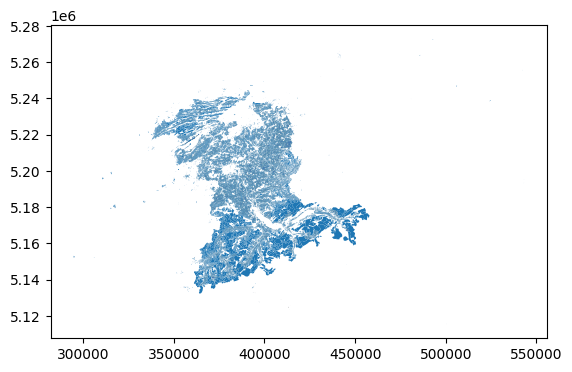

In [170]:
gdf_32632.plot()

In [171]:
from sentinelhub import (
    CRS,
    BBox,
    bbox_to_dimensions
)

c:\Users\danie\.virtualenvs\AgroLuege-HGn9_VQi\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Sentinel stellt Funktionen bereit, die mithilfe des Parameters "resolution" die Pixelgrösse angibt. Damit können wir einen durch 240 pixel (=2.4km) teilbaren Ausschnitt wählen, den wir jeweils mit einem request bei Sentinel abfragen können.
Wir werden ein Mosaik aus 23 x 41 Elementen haben für den Kanton Bern.

In [172]:
x_start = 361630.678100406
y_start = 5140066.039024595
x_end = x_start + 23*2400
y_end = y_start + 41*2400
bbox_to_dimensions(BBox(bbox=(x_start, y_start, x_end, y_end), crs=32632), resolution=10)

(5520, 9840)

In [173]:
area_box = []
x_start = 361630.678100406
y_start = 5140066.039024595
step= 2400
x_end = x_start + 23*step
y_end = y_start + 41*step
x_coordinate = list(np.arange(x_start, x_end, step))
y_coordinate = list(np.arange(y_start, y_end, step))
for i in range(len(x_coordinate)):
    for j in range(len(y_coordinate)):
        area = gdf_32632.cx[x_coordinate[i]:x_coordinate[i]+2400, y_coordinate[j]:y_coordinate[j]+2400].Shape_Area.sum()/1000000
        box_entry = {'x1': x_coordinate[i], 'y1': y_coordinate[j],'x2': x_coordinate[i]+2400,'y2': y_coordinate[j]+2400, 'area': area}
        area_box.append(box_entry)
area_boxes = pd.DataFrame(area_box)

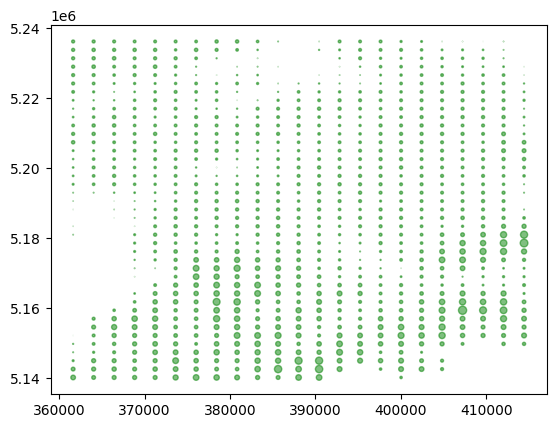

In [176]:
plt.scatter(x='x1', y='y1', s='area', data=area_boxes, alpha=0.5, c='g')

In [174]:
area_boxes.replace(0, np.nan, inplace=True)
print(area_boxes.area.isna().sum())

79


In [180]:
bboxes = area_boxes.copy()
bboxes = bboxes.dropna(subset = ['area'])
bboxes.to_csv('../raw_data/BernCrop/bboxes_sentinel.csv')
bboxes = bboxes.drop(columns=['x2', 'y2', 'area'])

<Axes: >

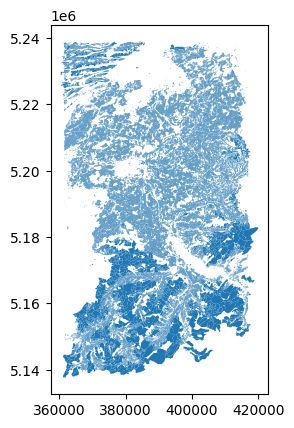

In [181]:
gdf_32632.cx[x_start:x_end, y_start: y_end].plot()

# Rasterize GIS-Data
Die Polygonzüge der einzelnen Landwirtschaftsfelder haben jeweils ein LNF_Code hinterlegt. In einem ersten Schritt wird jedem Polygonzug das Label der 3. Hierarchie (3level) hinterlegt. Die Originaldaten des Kanton Bern werden in das erforderliche Koordinatensystem WGS 84 / UTM zone 32N umgewandelt.
In einem zweiten Schritt werden die Polygon-Label auf Rasterebene umgewandelt, so dass jedes Pixel (10 x 10m) ein Label hat. Das Ergebnis ist eine Liste von numpy-arrays, bei dem jeder array die 2.4 x 2.4km der Sentinel-Abfrage darstellt.

In [155]:
gdf_pair = gdf_32632[['geometry', 'level3']]

In [159]:
test_gdf = gdf_pair.itertuples(index=False, name=None)
test_gdf = list(test_gdf)


In [160]:
def raster(coord, geo_df):
    """
    coord: DataFrame with x and y coordinates of bounding_boxes
    geo_df: geopandas with geometry, value pair
    """
    list = []
    for i in range(len(coord)):
               
        x_coord = coord.iloc[i,0] 
        y_coord = coord.iloc[i,1]
    
        with rasterio.Env():
            result = rasterize(geo_df, out_shape=(240, 240), transform = (10, 0, x_coord, 0, -10, y_coord, 0, 0, 1))
            list.append(result)
            
    return list

In [161]:
result_zero = raster(bboxes, test_gdf)


In [166]:
result_zero[800]

array([[27., 27., 27., ...,  0.,  0.,  0.],
       [27., 27., 27., ...,  0.,  0.,  0.],
       [27., 27., 27., ...,  0.,  0.,  0.],
       ...,
       [27., 27., 27., ...,  0.,  0.,  0.],
       [27., 27., 27., ...,  0.,  0.,  0.],
       [27., 27., 27., ...,  0.,  0.,  0.]], dtype=float32)

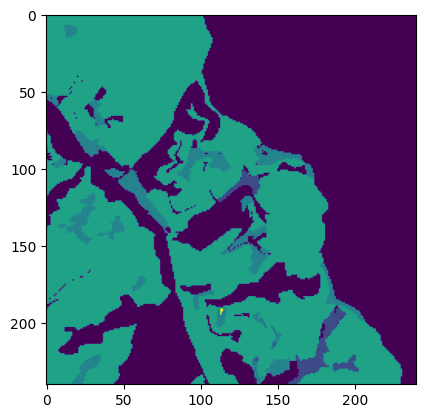

In [165]:
plt.imshow(result_zero[800])

In [167]:
import torch

tensor_label = torch.Tensor(result_zero)

C:\Users\danie\AppData\Local\Temp\ipykernel_14028\572462223.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:264.)
  tensor_label = torch.Tensor(result_zero)


In [168]:
tensor_label.size()

torch.Size([832, 240, 240])

In [169]:
torch.save(tensor_label, '../raw_data/BernCrop/tensor_label.pt')